In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import collections

In [2]:
%matplotlib notebook

In [3]:
def interpolate(a=[], b=[], amt=0.5):
    """ Linear interpolation for each dimension i in a,b
    a,b: array-like or float
    """
    return (1-amt) * a + amt * b
    

class Iterator:
    # Generate species identifiers (index values/keys)
    def __init__(self, start=0):
        self._next = start
        
    def get_next(self):
        # Return next identifier value and update internal state
        self._next += 1
        return self._next - 1

# Bak-Sneppen class and Lattice class

In [4]:
class Avalanches:
    # Data collector
    def __init__(self):
        self.trace = []
        self.min_fitness = 1
        self.size = -1
        
    def update(self, t, fitness):
        if t > 2 and fitness < self.min_fitness:
            self.size += 1
        else:
            self.trace.append(self.size)
            self.min_fitness = fitness
            self.size = 1
        
class BS:
    def __init__(self, N, network, random_relations=False, species_ids=None, fitnesses=None):
        """ Bak-Sneppen Model
        g: graph of the co-evolution dependencies
        network: type of graph
        """
        self.network = network
        # create graph
        if network[0] == "watts-strogatz":
            (_, k, p) = network
            self.g = nx.watts_strogatz_graph(N, k, p)
            if species_ids is None:
                species_ids = range(N)
            if fitnesses is None:
                fitnesses = np.random.random(N)
            if random_relations:
                random_indices = np.random.permutation(N)
                species_ids = species_ids[random_indices]
                fitnesses = fitnesses[random_indices]
            for node in self.g:
                self[node]["id"] = species_ids[node]
                self[node]["fitness"] = fitnesses[node]

        else:
            raise ValueError("Unknown network type") 


    def update(self, node_id, new_species_id, fitness=None):
        if fitness is None:
            fitness = np.random.random()
        self[node_id]["fitness"] = fitness
        self[node_id]["id"] = new_species_id
            
    @property
    def N(self):
        return self.g.number_of_nodes()

    def __getitem__(self, i):
        return self.g.node[i]

    @property
    def species(self):
        return self.g.nodes.data("id")
    
    @property
    def species_list(self):
        return [i for _,i in self.species]
    
    def fitness(self):
        return self.g.nodes.data("fitness")
    
    def fitness_array(self):
        return np.array([f for _,f in self.fitness()])
    
    def min_fitness(self):
        return min(self.fitness(), key=lambda x: x[1])
    
    def max_fitness(self):
        return max(self.fitness(), key=lambda x: x[1])
    
    def sorted_fitness(self):
        return sorted(self.fitness(), key=lambda x: x[1])
    
    def contains(self, species_id) -> bool:
        return species_id in self.species_list

In [19]:
class Lattice:
    def __init__(self, dimensions, N, network, P, fitness_correlation=1, migration_bias=1):
        """
        dimension: shape of lattice, e.g. N x N
        P: probability of mutation (Bernoulli trial)
            success -> mutation (replacement by new species)
            fail -> migration (replacement by a species originating from neighbourhood)
        fitness_correlation: float in [0,1]
            Parameter that controls fitness after migration. 
            Low values maintain the previous fitness and high values randomize the fitness.
        migration_bias: float in [-1,1]
            Parameter to controll the influence of fitness on migration. Set to zero to disable the influence.
        """
        self.data = None
        self.N_species = N
        self.dimensions = dimensions
        self.P = P
        self.identifier_iter = Iterator(start=np.prod(dimensions) * N)
        self.fitness_correlation = fitness_correlation
        self.migration_bias = migration_bias
        # create lattice
        self.lattice = nx.grid_graph(list(dimensions), periodic=True)
        self.av = Avalanches()
        self.av_local = Avalanches()
        # create BS network in each point of the lattice
        for (i, point) in enumerate(self.lattice):
            self.lattice.node[point]["BS"] = BS(N, network, species_ids=range(N*i, N*(i+1)), fitnesses=None)


    def __getitem__(self, i):
        return self.lattice.node[i]["BS"]

    @property
    def N(self):
        return self.lattice.number_of_nodes()
    
    def run(self, t_max: int, collect_data=False):
        if collect_data:
            self.data = np.empty((t_max+1,) + self.dimensions, dtype=object)
            for i,j in np.ndindex(self.dimensions):
                self.data[0, i, j] = set(self[i, j].species_list)
        
        for t in range(1, t_max+1):
            self.run_step(t, collect_data)

    def run_step(self, t, collect_data):
        # Randomize update order to reduce iteration-order side effects
        global_fitness = 1
        for i, j in np.random.permutation(self.lattice):
            # select node with lowest fitness
            bs = self[i,j]
            lattice_neighbours = list(self.lattice[i,j])
            idx, fitness = bs.min_fitness()
            node_indices = [idx] + list(bs.g[idx])
            # count local avalanches
            if i == 0 and j == 0:
                self.av_local.update(t, fitness)
            
            # apply mutation-migration step for each node
            for node_id in node_indices:
                if np.random.random() < self.P:
                    self.mutate(bs, node_id)
                else:
                    self.migrate(bs, node_id, lattice_neighbours)

            if collect_data:
                self.data[t, i, j] = set(bs.species_list)

            global_fitness = min(fitness, global_fitness)
        self.av.update(t, fitness)

    def mutate(self, bs, node_id):
        bs.update(node_id, self.identifier_iter.get_next())
        
    def migrate(self, bs, node_id, lattice_neighbours=[]):
        # select a random neighbour as migration source
        bs_source = self[lattice_neighbours[np.random.randint(0, len(lattice_neighbours))]]
        source_nodes = bs_source.g
        if self.migration_bias != 0:
            nodes = bs_source.g.nodes
            # sort based on fitness
            reverse = self.migration_bias > 0
            nodes = bs_source.g.nodes
            source_nodes = sorted(source_nodes,
                                  key=lambda node_i: nodes[node_i]['fitness'],
                                  reverse=reverse)
        else:
            # select all source species
            source_nodes = np.random.permutation(source_nodes)

        # use dummy dict to optimize lookup
        target_species_ids = {k[1]:None for k in bs.species}
        # iterate randomly over selection
        for source_node_id in source_nodes:
            species_id = bs_source[source_node_id]["id"]
            # let the species migrate from source to target bs
            if species_id not in target_species_ids:
                # migrate and stop searching
                fitness_new = interpolate(bs_source[source_node_id]["fitness"], 
                                          np.random.random(), 
                                          amt=1-self.fitness_correlation)
                bs.update(node_id, species_id, fitness=fitness_new)
                return

        print("Migration failed from {} to {}".format(bs_source.species, bs.species))
        self.mutate(bs, node_id)

    def draw(self):
        nx.draw(self.lattice, with_labels=True)
    
    def mean_species(self):
        ids = set()
        for point in self.lattice:
            ids = ids.union(self[point].species_list)
        return len(ids) / np.prod(self.dimensions)

    def fitness_stats(self):
        fitness = self.avg_fitness_per_point()        
        return np.mean(fitness), np.std(fitness)
    
    def avg_fitness(self):
        # avg of avg fitness per point
        fitness = self.avg_fitness_per_point()
        return np.mean(fitness)

    def avg_fitness_per_point(self):
        return [self[point].fitness_array().mean() for point in self.lattice]
    
    def area_curve(self, sampling_scheme='quadrats', log=True, plot_bool=True, v=0):
        # sampling_scheme = ['nested'|'quadrats']
        if sampling_scheme == 'nested':
            area_curve = np.empty((self.dimensions[0],2))
            for s in range(1, self.dimensions[0]+1):
                species = set()
                for i in range(0, s):
                    for j in range(0, s):
                        species = species.union(self[(i,j)].species_list)

                nr = len(species)
                area_curve[s-1] = (s**2, nr)
            print(area_curve)
            ax.plot(*area_curve.T, "o")
            
            power = (np.log10(area_curve[-1,1]) - np.log10(area_curve[0,1])) / (np.log10(self.dimensions[0]**2) - np.log10(1))


        elif sampling_scheme == 'quadrats':
            area_curve = collections.OrderedDict()
            sd = []
            for grain_size in range(1, max(self.dimensions)+1):
                assert self.dimensions[0] == self.dimensions[1]
                means = []
                i = 0
                for interval_i in range(0, self.dimensions[0]-grain_size+1):
                    for interval_j in range(0, self.dimensions[1]-grain_size+1):
                        species = set()
                        for i,j in np.ndindex((grain_size,grain_size)):
                            ii = interval_i + i
                            jj = interval_j + j
                            species = species.union(self[ii,jj].species_list)
                            i += 1

                        means.append(len(species))
                
                area_curve[grain_size**2] = np.mean(means)
                sd.append(np.std(means)*1.96/np.sqrt(i))
                if plot_bool and v > 0:
                    print('grain size: %i, mean: %0.3f'% (grain_size, np.mean(means)))
            
            X = np.log10(np.array([list(area_curve.keys())])).T[2:]
            y = (np.log10(np.array([list(area_curve.values())])).T - np.log10(self.N_species))[2:]
            power, res = np.linalg.lstsq(X,y)[0:2]
            res = np.mean(res)
            
            if plot_bool:
                fig, ax = plt.subplots()
                ax.errorbar(list(area_curve.keys()), list(area_curve.values()), yerr=sd, fmt="x", capsize=2)
                ax.plot()
                ax.plot(list(area_curve.keys()), (self.N_species * np.array(list(area_curve.keys()))**power)[0], color='red', linestyle='dashed')
                ax.set_xlabel("Area")
                ax.set_ylabel("Number of species")

                if log:
                    ax.set_xscale("log")
                    ax.set_yscale("log")
                    
        print("power: {}, MSE: {}".format(round(power[0][0], 3), res))
        return power[0][0], res
    
    def avg_n_species(self, grain_size: int, species=None):
        # Compute mean, std number of species per area using "quadrats" sampling scheme
        means = []
        i = 0
        for interval_i in range(0, self.dimensions[0]-grain_size+1):
            for interval_j in range(0, self.dimensions[1]-grain_size+1):
                unique_species = set()
                for i,j in np.ndindex((grain_size,grain_size)):
                    ii = interval_i + i
                    jj = interval_j + j
                    if species is None:
                        unique_species = unique_species.union(self[ii,jj].species_list)
                    else:
                        unique_species = unique_species.union(species[ii,jj])
                    i += 1

                means.append(len(unique_species))

        mean = np.mean(means)
        std = np.std(means)*1.96/np.sqrt(i)
        return mean, std

In [20]:
def plot_avg_n_species_per_t(lattice, title='Avg number of species over time (for different grain sizes)'):
    # Plot mean species per area using "quadrats" sampling scheme
    assert lattice.data is not None, 'use Lattice.run(collect_data=True)'    
    t_max = lattice.data.shape[0]
    step_size = int(t_max / 100)
    for grain_size in range(1, max(lattice.dimensions)+1):
#     for grain_size in range(1, 4):
        means = []
        for t, species in enumerate(lattice.data[::step_size]):
            mean, std = lattice.avg_n_species(grain_size, species)
            means.append(mean)
        plt.plot(means, label='grain size: %i' % grain_size)
    plt.plot([0,t], [lattice.N_species, lattice.N_species], '--', label='Minimum N species')
    plt.legend()
    plt.margins(0)
    plt.xlabel('t (1/%i)' % step_size)
    plt.ylabel('Avg number of species')
    plt.title(title)
    plt.yscale('log')

# Experiments

In [21]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=0, migration_bias=1)
# %time l.run(2000, collect_data=False)
%time l.run(1000, collect_data=True)

CPU times: user 13.8 s, sys: 183 ms, total: 14 s
Wall time: 14.9 s


In [26]:
len(l.av_local.trace), len(l.av.trace), l.data.shape

(49, 23, (1001, 10, 10))

<IPython.core.display.Javascript object>


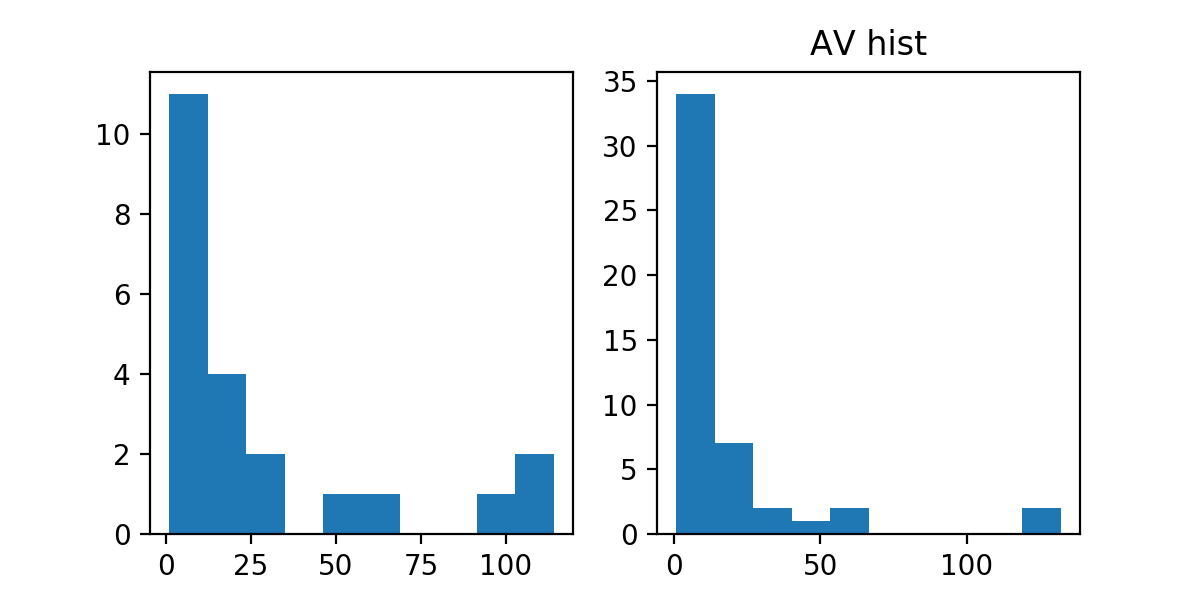

Text(0.5, 1.0, 'AV hist')

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
ax1.hist(l.av.trace[1:], bins=10)
ax2.hist(l.av_local.trace[1:], bins=10)
plt.title('AV hist')

In [37]:
# fig = plt.figure(figsize=(5,5))
# plt.plot(l.av.trace[1:], label='AV')
# plt.plot(l.av_local.trace[1:], label='AV local')
# plt.title('AV')
# plt.ylabel('AV size')
# plt.xlabel('t')
# plt.legend()
# plt.yscale('log')
# plt.margins(0)

<IPython.core.display.Javascript object>


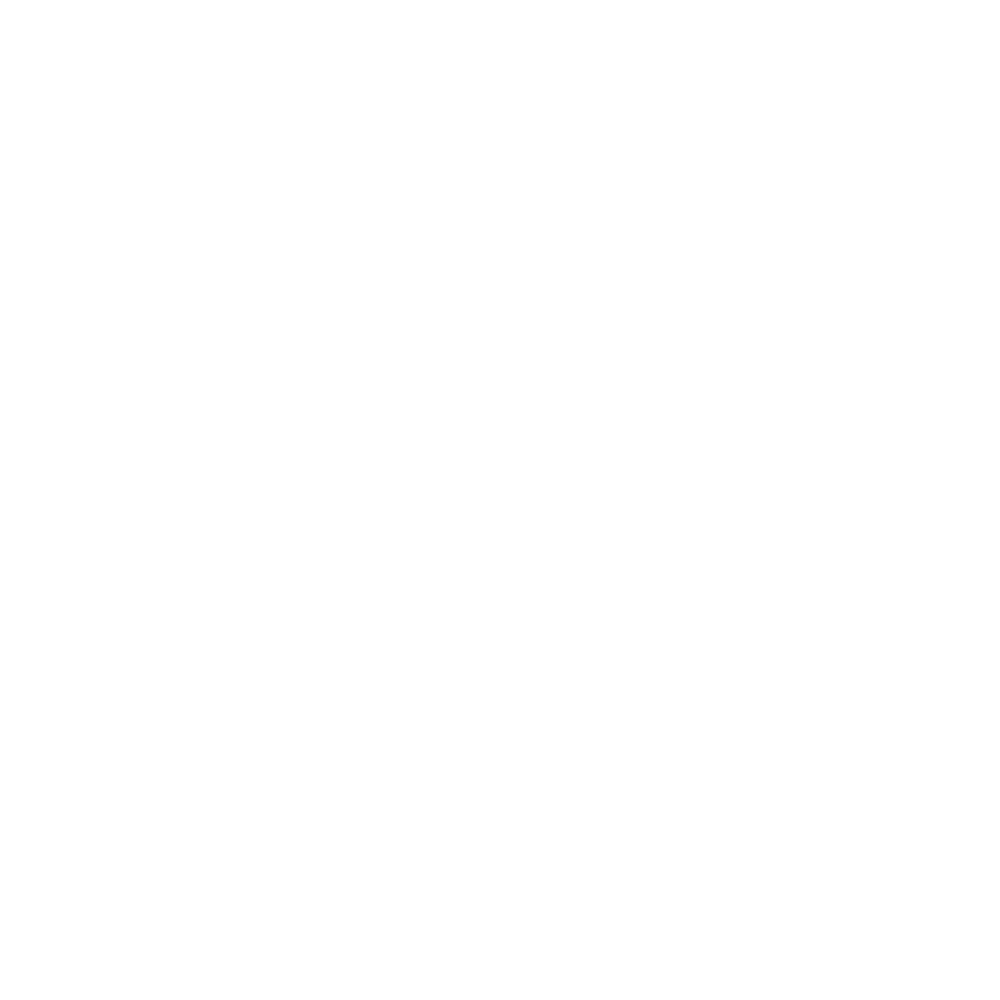

value: 0.00
value: 0.25
value: 0.50
value: 0.75


KeyboardInterrupt: 

In [29]:
plt.figure(figsize=(5,5))
x = np.linspace(0,1,5)
for i, migration_bias in enumerate([-1,0,1]):
    avg_fitnesses = []
    for value in x:
        print('value: %0.2f' % value)
        l = Lattice((5,5), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=value, migration_bias=migration_bias)
        l.run(1000, collect_data=False)
        avg_fitnesses.append(l.avg_fitness())
    plt.plot(x, avg_fitnesses, label='migration bias: %i' % migration_bias)
plt.xlabel('fitness correlation')
plt.ylabel('avg fitness')
plt.ylim([0,1])
plt.legend()
plt.margins(0)
plt.title('Effect of fitness corr. and migration bias on\n avg fitness')

<IPython.core.display.Javascript object>


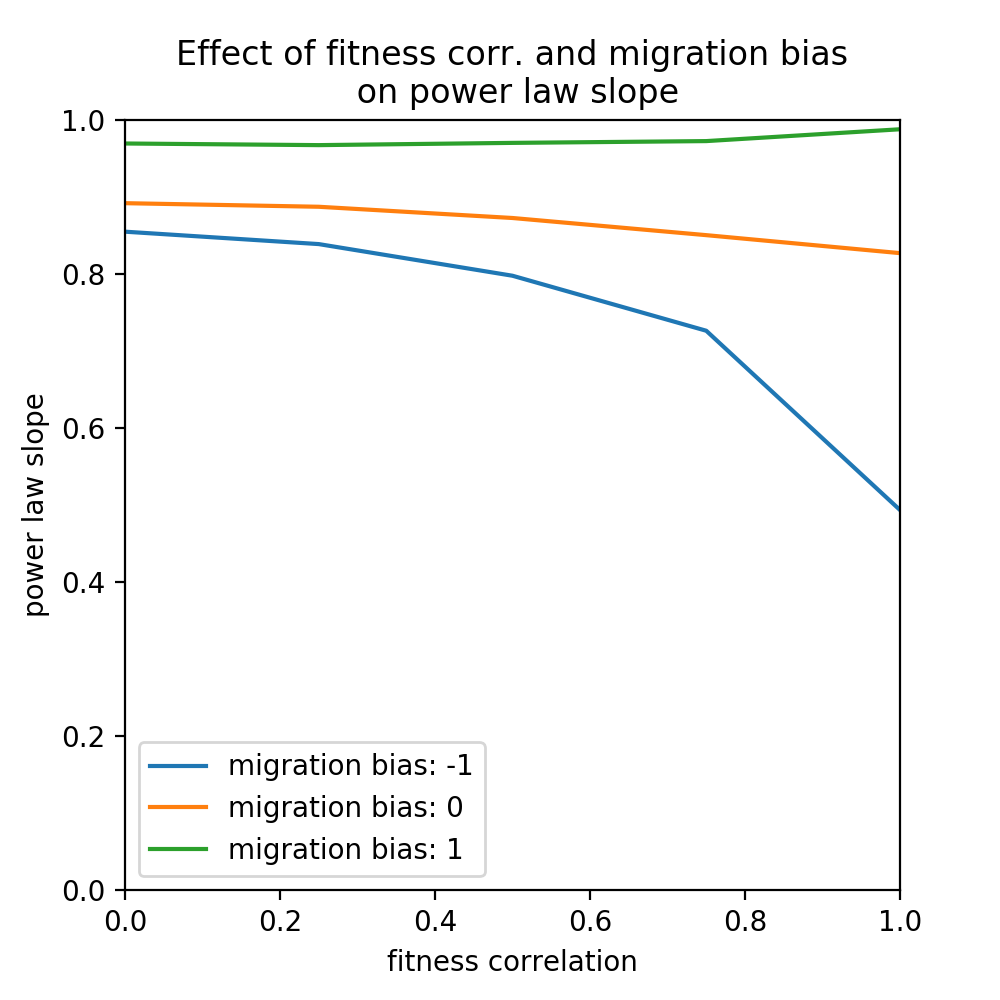

value: 0.00


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:159: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


power: 0.855, MSE: 9.136844944986144e-06
value: 0.25
power: 0.839, MSE: 9.808478508067056e-05
value: 0.50
power: 0.798, MSE: 0.0003899549506924196
value: 0.75
power: 0.726, MSE: 0.0003687786601807934
value: 1.00
power: 0.493, MSE: 0.003328123161203453
value: 0.00
power: 0.892, MSE: 0.0002243127764605522
value: 0.25
power: 0.887, MSE: 0.00022768372580898776
value: 0.50
power: 0.873, MSE: 0.0004665459892856636
value: 0.75
power: 0.85, MSE: 0.00048416612995611966
value: 1.00
power: 0.827, MSE: 0.001065172300496057
value: 0.00
power: 0.969, MSE: 6.920990867500753e-05
value: 0.25
power: 0.967, MSE: 6.515939155568366e-05
value: 0.50
power: 0.97, MSE: 6.239676117074348e-05
value: 0.75
power: 0.973, MSE: 3.0740739062582936e-05
value: 1.00
power: 0.988, MSE: 1.7911080629202402e-06


Text(0.5, 1.0, 'Effect of fitness corr. and migration bias\n on power law slope')

In [81]:
plt.figure(figsize=(5,5))
x = np.linspace(0,1,5)
for i, migration_bias in enumerate([-1,0,1]):
    slopes = []
    for value in x:
        print('value: %0.2f' % value)
        l = Lattice((5,5), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=value, migration_bias=migration_bias)
        l.run(100, collect_data=False)
        slopes.append(l.area_curve('quadrats', plot_bool=False)[0])
        
    plt.plot(x, slopes, label='migration bias: %i' % migration_bias)

plt.xlabel('fitness correlation')
plt.ylabel('power law slope')
plt.ylim([0,1])
plt.legend()
plt.margins(0)
plt.title('Effect of fitness corr. and migration bias\n on power law slope')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:161: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


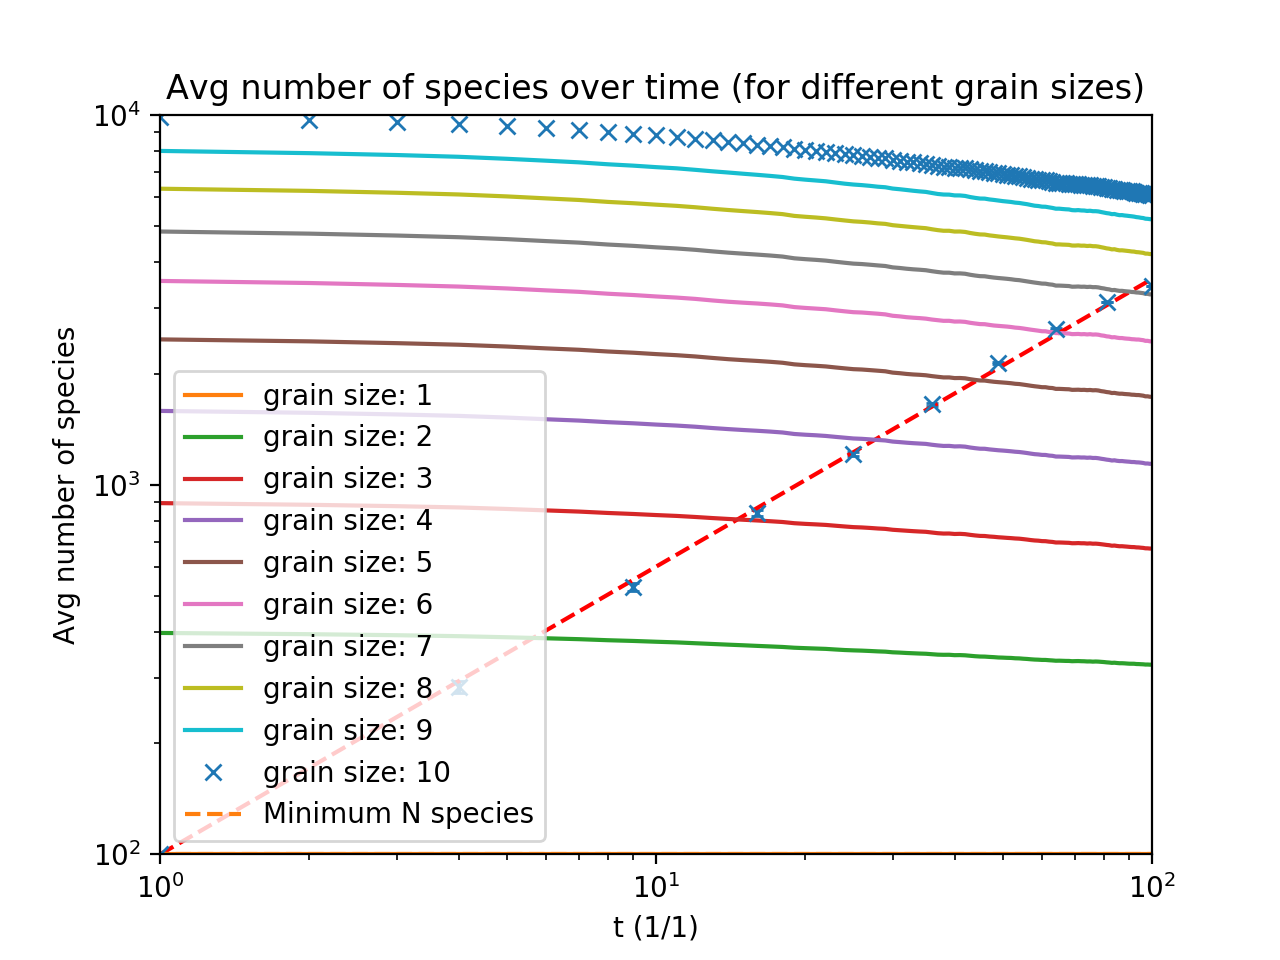

power: 0.778, MSE: 0.001435125343050481


(0.7784506351967325, 0.001435125343050481)

In [11]:
l.run(1000, collect_data=False)
l.area_curve("quadrats", plot_bool=True)

<IPython.core.display.Javascript object>


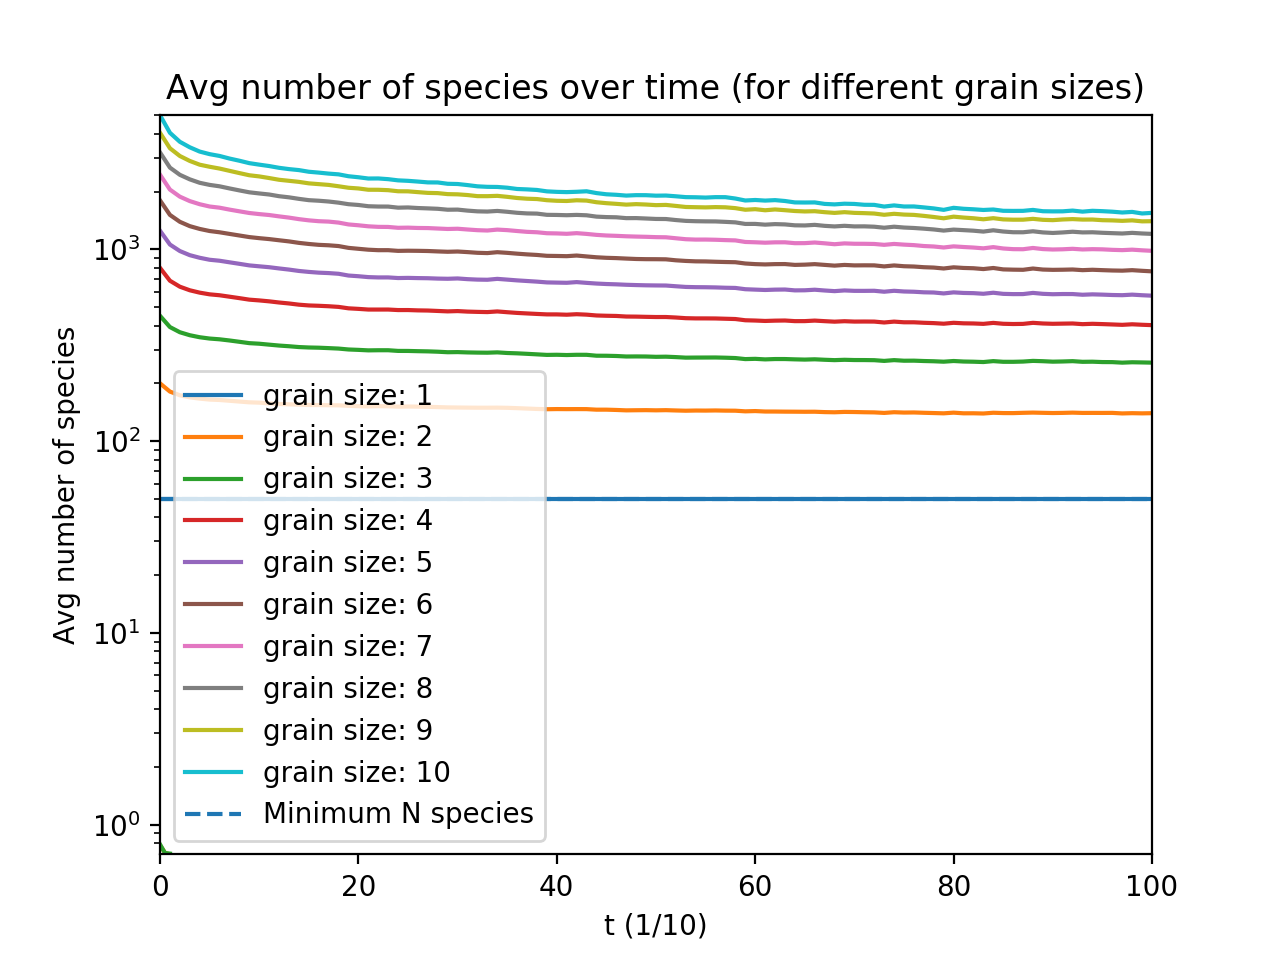

In [9]:
l = Lattice((10,10), N=50, network=("watts-strogatz", 3, 0),
            P=1/2, fitness_correlation=0, migration_bias=0)
l.run(1000, collect_data=True)
plot_avg_n_species_per_t(l)

In [ ]:
# plot avg_n_species over time for different params

# # grid search
# params = {'fitness_correlation': [0,0.5], 'migration_bias': [0, 0.5]}
# fig = plt.figure(figsize=(8,8))
# k1 = list(params.keys())[0]
# i = 0
# for v1 in params[k1]:
#     k2 = list(params.keys())[1]
#     for v2 in params[k2]:
#         i += 1
#         kwargs = {k1: v1, k2: v2}
#         print(kwargs)
#         Lattice((5,5), N=N, network=("watts-strogatz", 3, 0), P=1/3, **kwargs)
#         l.run(1000, collect_data=True)
#         plt.subplot(2,2,i)
#         plot_avg_n_species_per_t(l, title='%s:%0.2f,\n %s: %0.2f' % (k1, v1, k2,v2))
# plt.tight_layout()

## Area curve over time

<IPython.core.display.Javascript object>


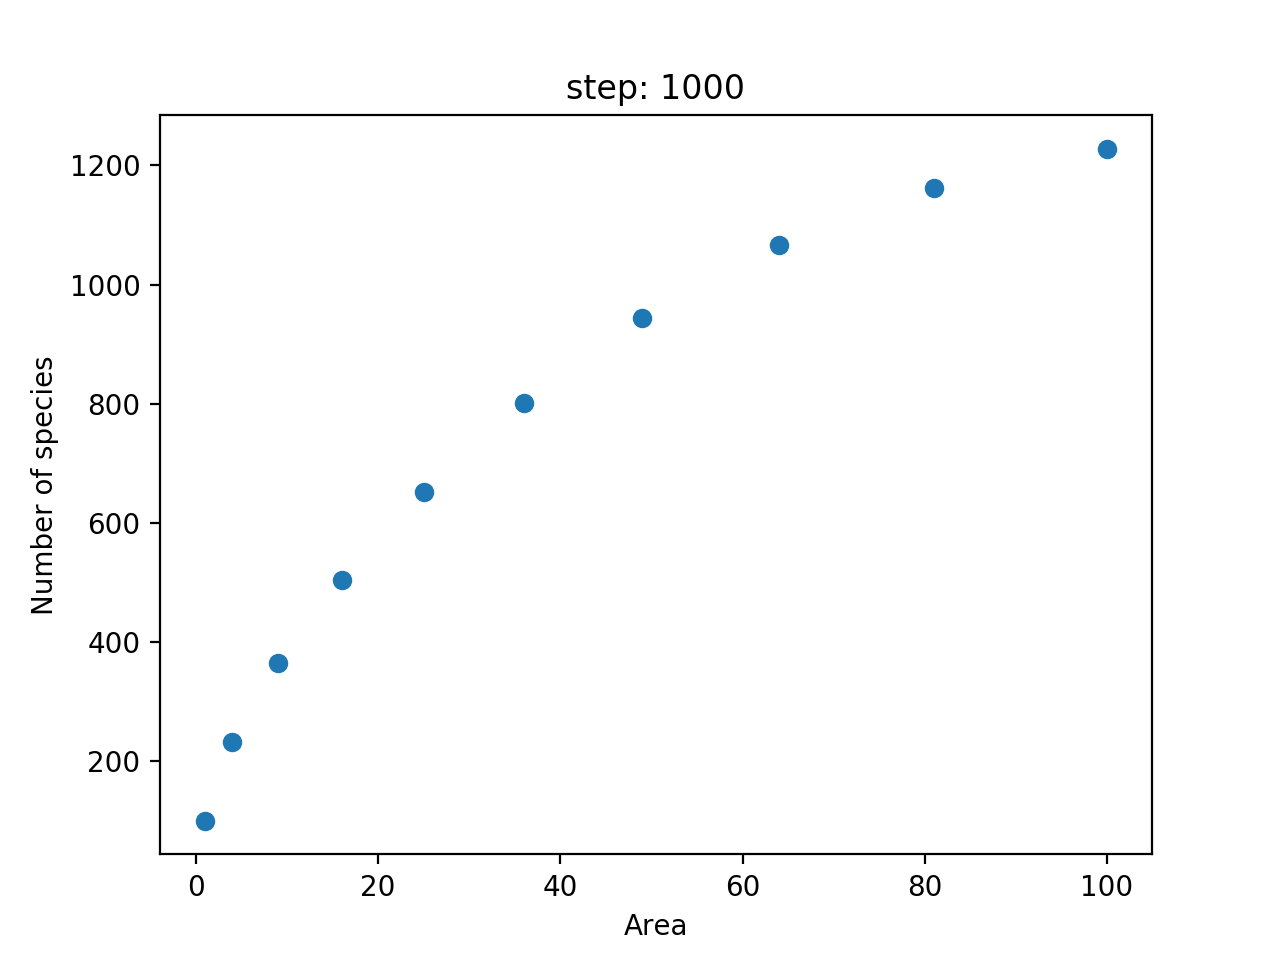

In [8]:
fig, ax = plt.subplots()
line, = ax.plot([],[], "o")
ax.set_xlabel("Area")
ax.set_ylabel("Number of species")
# ax.set_xscale("log")
# ax.set_yscale("log")

step_size = 10

def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))

    # calculate area curve
    area_curve = collections.OrderedDict()
    for grain_size in range(1, max(l.dimensions)+1):
        means = []
        i = 0
        for interval_i in range(0, l.dimensions[0]-grain_size+1):
            for interval_j in range(0, l.dimensions[1]-grain_size+1):
                unique_species = set()
                for i,j in np.ndindex((grain_size,grain_size)):
                    ii = interval_i + i
                    jj = interval_j + j
                    unique_species = unique_species.union(species[ii,jj])
                    i += 1

                means.append(len(unique_species))

        area_curve[grain_size**2] = np.mean(means)
    line.set_xdata(list(area_curve.keys()))
    line.set_ydata(list(area_curve.values()))

    ax.relim()
    ax.autoscale_view()

    return line

ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=100, repeat=False, blit=True, save_count=1000)

## Species migration over lattice

<IPython.core.display.Javascript object>


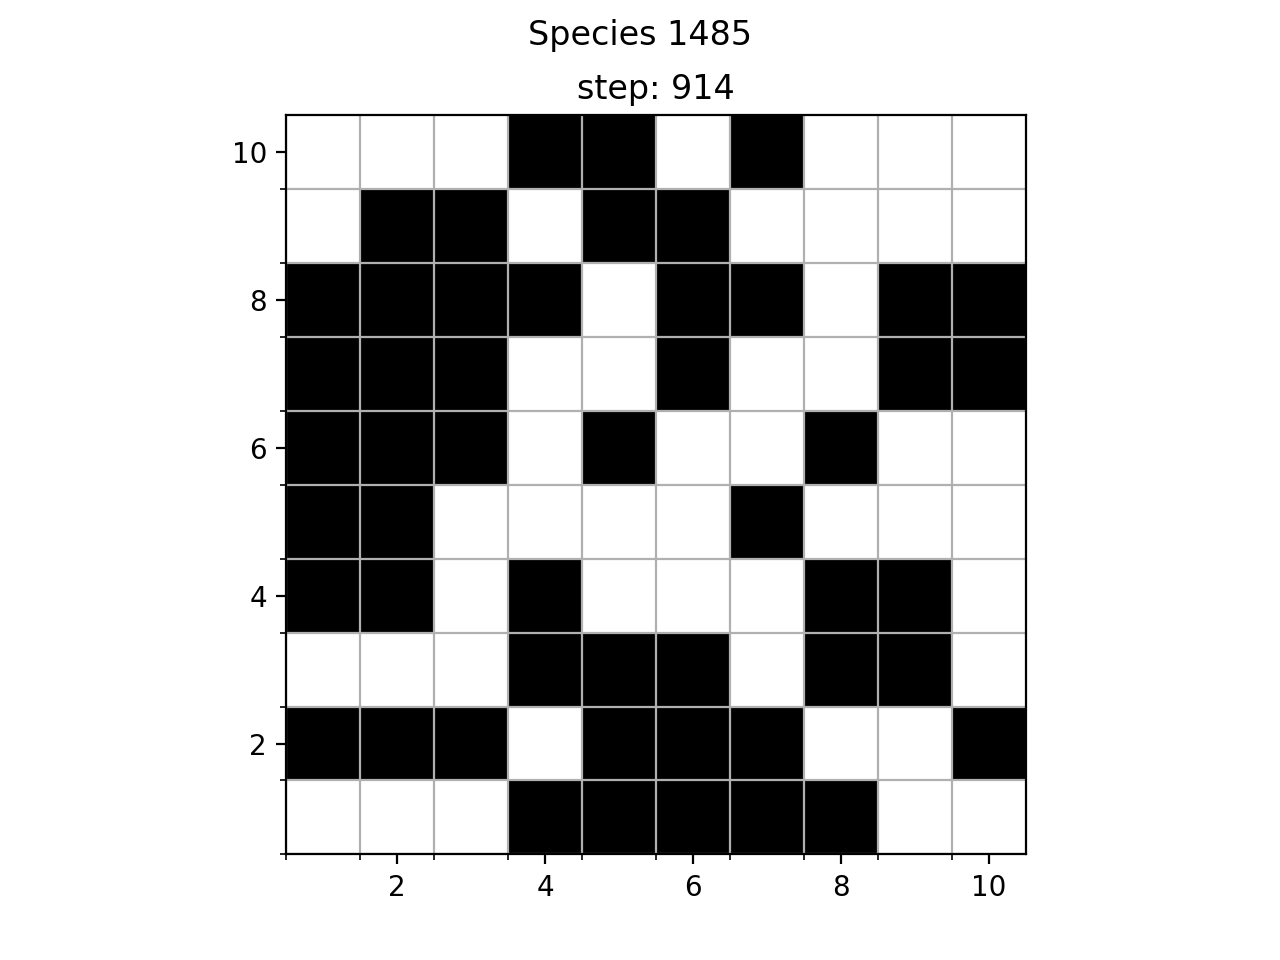

In [9]:
species_count = collections.Counter([x for l in l.data.flatten() for x in l])
spec_id, _ = species_count.most_common(1)[0]

im_data = np.zeros(l.dimensions)

fig, ax = plt.subplots()
im = ax.imshow(im_data, cmap="binary", vmin=0, vmax=1,
               extent=(0.5, l.dimensions[0]+0.5, 0.5, l.dimensions[1]+0.5))
ax.set_xticks(np.arange(l.dimensions[0])+0.5, minor=True)
ax.set_yticks(np.arange(l.dimensions[1])+0.5, minor=True)
ax.grid(True, which="minor")

fig.suptitle("Species {}".format(spec_id))

step_size = 1

def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))
    
    for i,j in np.ndindex(l.dimensions):
        if spec_id in species[i,j]:
            im_data[i,j] += 0.5
        else:
            im_data[i,j] = 0
    im.set_data(im_data)
    
    return im

ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=50, repeat=False, blit=True, save_count=1000)

## Mean number of species over time

<IPython.core.display.Javascript object>


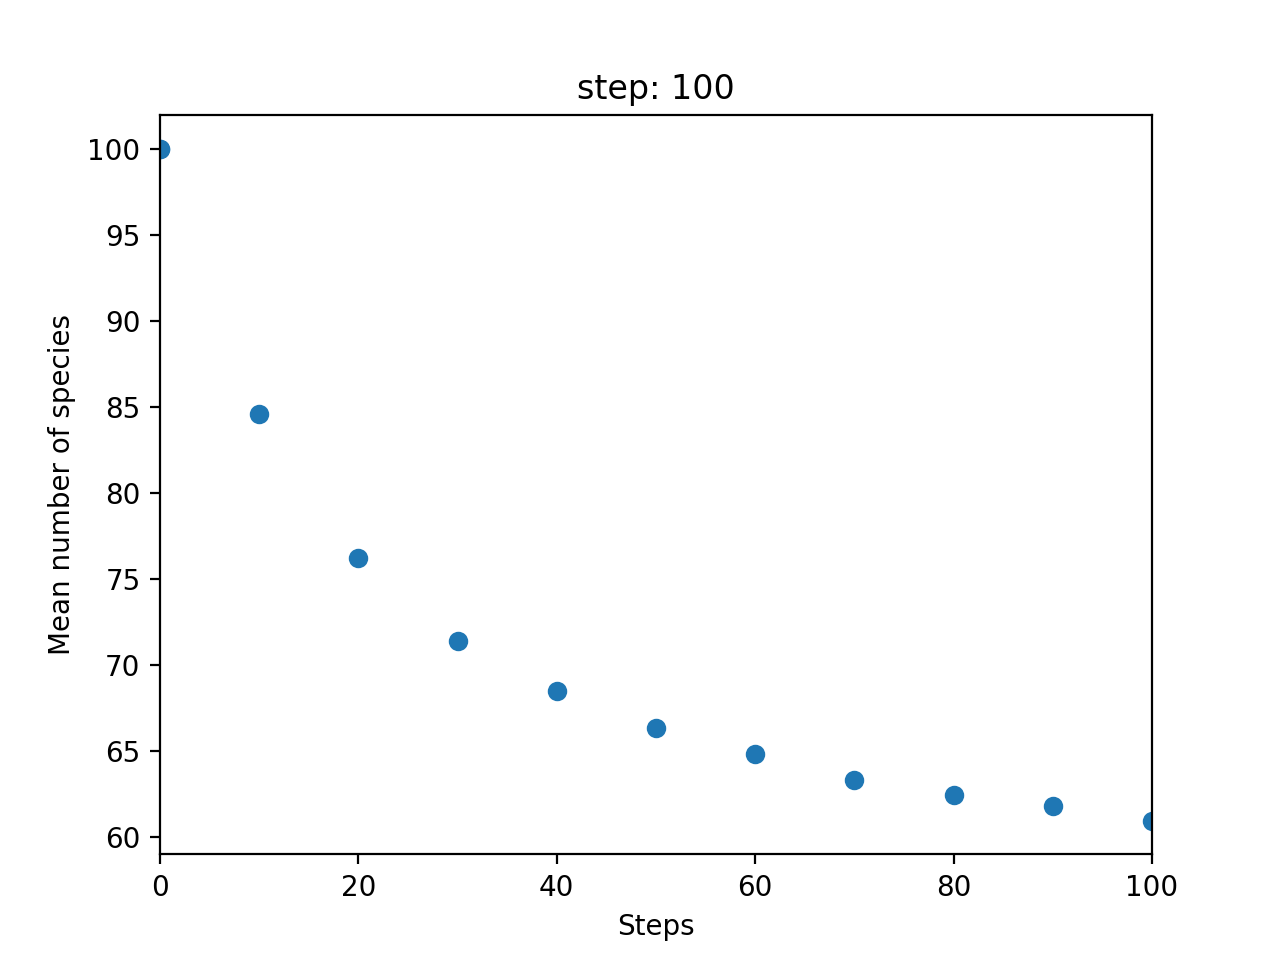

In [10]:
dimensions = (6,6)
l = Lattice(dimensions, 100, ("watts-strogatz", 3, 0), 1/3)
step_size = 10
steps = 10

fig, ax = plt.subplots()
line, = plt.plot([],[], "o")
ax.set_xlim(0, steps*step_size)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean number of species")

def animate(i):
    if i > 0:
        l.run(step_size)

    t = i * step_size
    
    ax.set_title("step: {}".format(t))
    line.set_xdata(np.append(line.get_data()[0], [t]))
    line.set_ydata(np.append(line.get_data()[1], [l.mean_species()]))
    
    ax.relim()
    ax.autoscale_view()
    
    return line

ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=500, repeat=False, blit=True, save_count=1000)

## Parameter testing

In [ ]:
path_slope = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/slope.pkl"
path_pow = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/law.pkl"
path_fit = "C:/Users/ruuds/aaaaComputational Science/Complex System Simulation/Complex-Systems/Complex-Systems/law.pkl"
iters = 10
fitness_correlation_list = np.linspace(0,1,iters)[:5]
migration_bias_list = np.linspace(-1,1,iters)
power_slope = np.zeros((iters, iters))
is_power_law = np.ones((iters, iters))
avg_fitness = np.zeros((iters, iters))

for i, fc in enumerate(fitness_correlation_list):
    for j, mb in enumerate(migration_bias_list):
        print(int(i), int(j))
        l = Lattice((10,10), N=100, network=("watts-strogatz", 3, 0),
                P=1/2, fitness_correlation=fc, migration_bias=mb)
        l.run(3000, collect_data=False)
        power_slope[int(i),int(j)], res = l.area_curve("quadrats",plot_bool=False)
        if (res > 0.015):
            is_power_law[int(i),int(j)] = 0
        avg_fitness[int(i),int(j)] = l.avg_fitness()

    f = open(path_slope,"wb")
    pickle.dump(power_slope,f)
    f.close()
    
    f = open(path_pow,"wb")
    pickle.dump(is_power_law,f)
    f.close()
    
    f = open(path_fit,"wb")
    pickle.dump(avg_fitness,f)
    f.close()

0 0


C:\Users\ruuds\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:160: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


power: 0.67, MSE: 0.002059729068872391
0 1
power: 0.66, MSE: 0.0029292862500503816
0 2
power: 0.676, MSE: 0.0030280926181111595
0 3
power: 0.666, MSE: 0.003338915080632637
0 4
power: 0.673, MSE: 0.002698872518384289
0 5
power: 0.665, MSE: 0.0023909893798596247
0 6
power: 0.662, MSE: 0.0028687251316713556
0 7
power: 0.665, MSE: 0.0038292414821599393
0 8
power: 0.673, MSE: 0.002451947567400884
0 9
power: 0.67, MSE: 0.0024576544223916356
1 0
power: 0.843, MSE: 0.0014400738783531268
1 1


In [82]:
a = pickle.load(open(path_pow, "rb"))

In [89]:
avg_fitness

array([[0.54321722, 0.54209558, 0.5389392 , 0.53787345, 0.55042312,
        0.54265297, 0.54434712, 0.54311797, 0.54777289, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       